# Extrapolate Wakefield results

In [1]:
import sys
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
from scipy.constants import c 

sys.path.append('../wakis/')
import wakis

sys.path.append('../IDDEFIX/')
import iddefix

Let's load the simulation results computed in the notebook `002`

In [2]:
wake10 = wakis.WakeSolver()
wake10.load_results('results_wl10/')

#wake1000 = wakis.WakeSolver()
#wake10.load_results('results_wl1000/')

Text(0.5, 0, 's [m]')

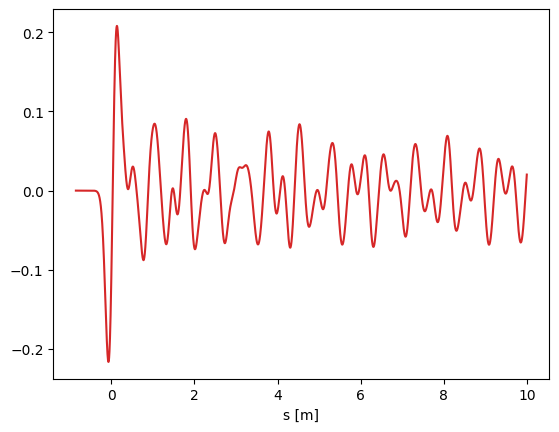

In [3]:
fig, ax = plt.subplots()
ax.plot(wake10.s, wake10.WP, c='tab:red', label='Wakelength = 10 m')
ax.set_xlabel('s [m]')

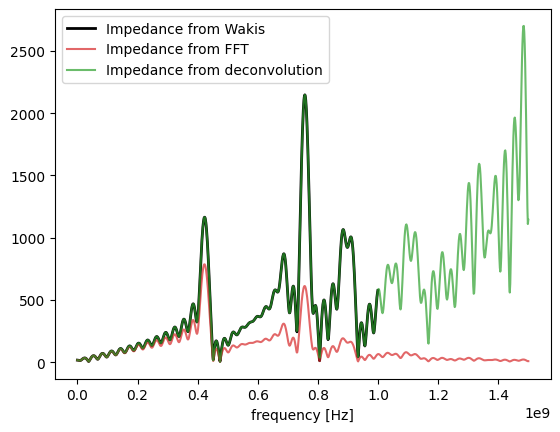

In [4]:
fig, ax = plt.subplots()
ax.plot(wake10.f, np.abs(wake10.Z), c='k', lw=2, label='Impedance from Wakis')
f, WP_fft = iddefix.compute_fft(wake10.s/c, wake10.WP*1e12/c, fmax=1.5e9)
ax.plot(f, np.abs(WP_fft), c='tab:red', alpha=0.7, label='Impedance from FFT')
f, Z = iddefix.compute_deconvolution(wake10.s/c, wake10.WP*1e12/c, fmax=1.5e9, sigma=10e-2/c)
ax.plot(f, np.abs(Z), c='tab:green', alpha=0.7, label='Impedance from deconvolution')
ax.set_xlabel('frequency [Hz]')
ax.legend()

Now we get the number of resonators and parameters for the Differential Evolution model `DE_model`

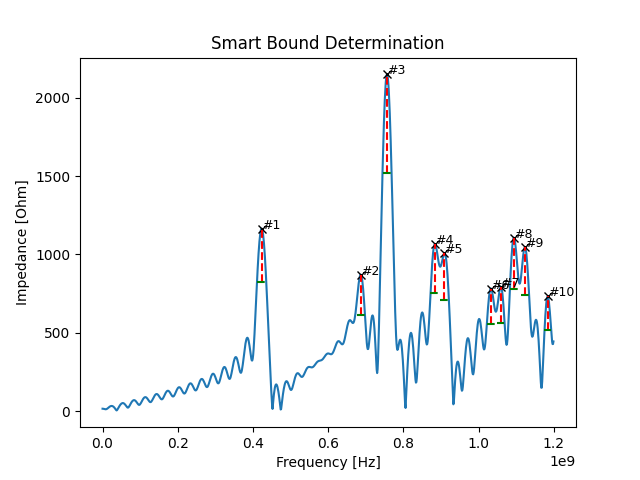

In [17]:
f,Z = iddefix.compute_deconvolution(wake10.s/c, wake10.WP*1e12/c, fmax=1.2e9, sigma=10e-2/c)

heights = np.zeros_like(Z)
heights[f<1.0e9] = 700
heights[f>=1.0e9] = 650
bounds = iddefix.SmartBoundDetermination(f, np.abs(Z), minimum_peak_height=heights)
bounds.inspect()

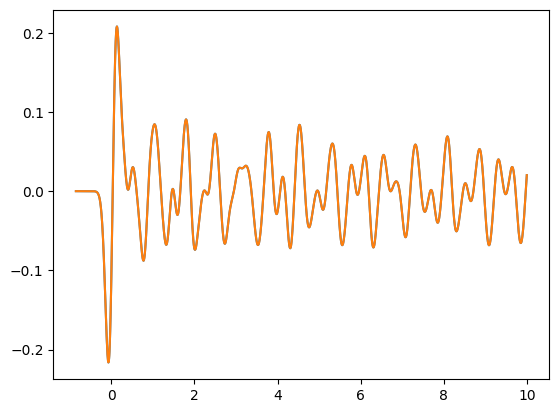

In [7]:
# Decimate data to improve speed
s = np.linspace(wake10.s[0],wake10.s[-1],1000)
WP = np.interp(s, wake10.s, wake10.WP)

plt.plot(wake10.s, wake10.WP)
plt.plot(s, WP)

In [8]:
%%time
DE_model = iddefix.EvolutionaryAlgorithm(s/c, 
                                         WP*1e12/c, 
                                         N_resonators=bounds.N_resonators, 
                                         parameterBounds=bounds.parameterBounds,
                                         sigma=10e-2/c,
                                         plane='longitudinal',
                                         fitFunction='wake potential', 
                                         #objectiveFunction=iddefix.ObjectiveFunctions.sumOfSquaredErrorReal
                                         ) 

# Run the differential evolution
DE_model.run_differential_evolution(maxiter=2000,
                                    popsize=180,
                                    tol=0.001,
                                    mutation=(0.1, 0.5),
                                    crossover_rate=0.8)
print(DE_model.warning)

Optimization Progress %:  99%|█████████▉| 99.23612759267867/100 [03:31<00:00,  3.22it/s]    /home/edelafue/miniconda3/envs/wakis-p10/lib/python3.10/site-packages/tqdm/std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
Optimization Progress %: 100%|██████████| 100.06700161022144/100 [03:32<00:00,  2.12s/it]



----------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |    fres [Hz]     
----------------------------------------------------------------------
    1     |        9.32e+02        |      88.20       |    4.160e+08     
    2     |        6.98e+02        |      178.47      |    6.827e+08     
    3     |        1.72e+03        |      157.72      |    7.666e+08     
    4     |        8.56e+02        |      181.82      |    8.848e+08     
    5     |        8.06e+02        |      188.27      |    9.101e+08     
    6     |        6.48e+02        |      235.42      |    1.033e+09     
    7     |        6.61e+02        |      270.15      |    1.061e+09     
    8     |        8.91e+02        |      249.63      |    1.091e+09     
    9     |        8.58e+02        |      288.72      |    1.117e+09     
    10    |        6.83e+02        |      338.83      |    1.181e+09     
------------------------------------------

Show fully decayed wake and impedance

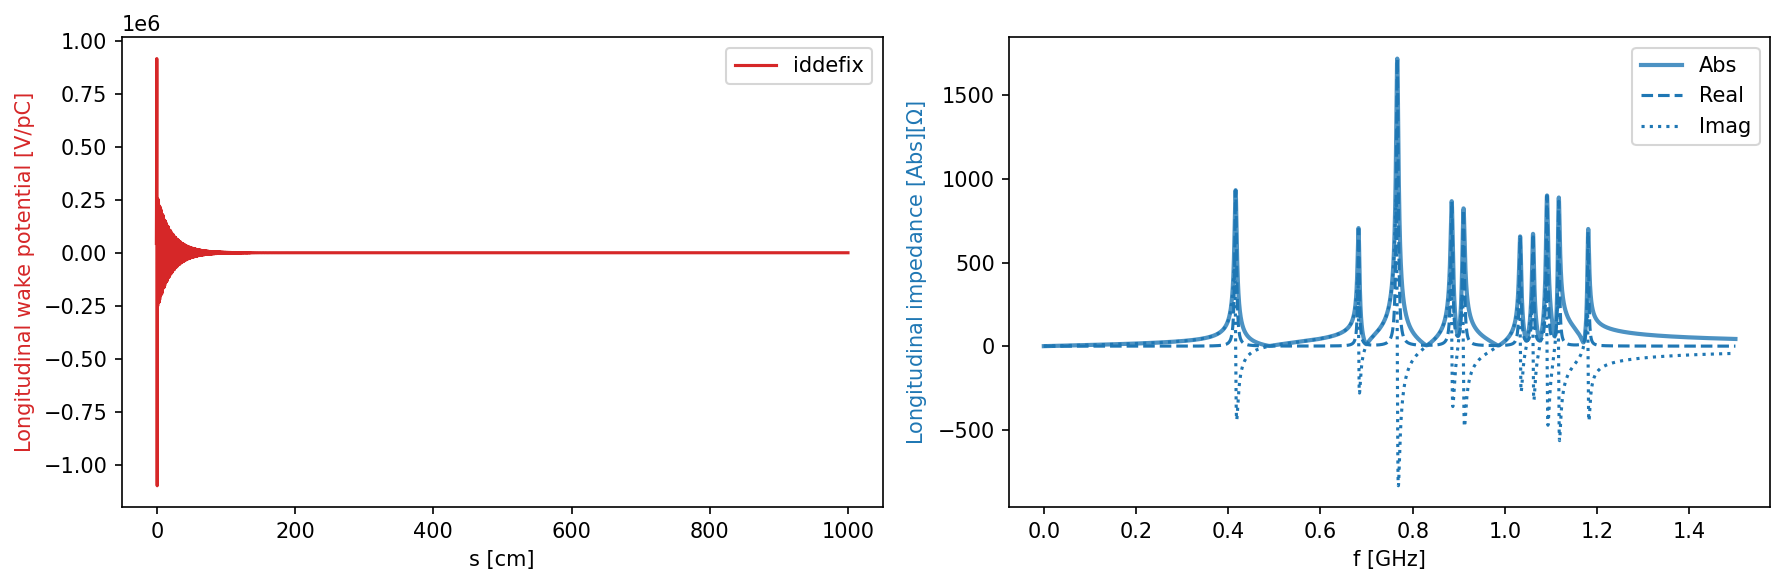

In [11]:
t_fd = np.linspace(wake10.s[0]/c, 1000/c, 10000)
WP_fd = DE_model.get_wake_potential(t_fd)

f_fd = np.linspace(0, 1.5e9, 10000)
Z_fd = DE_model.get_impedance(f_fd)

fig1, ax = plt.subplots(1,2, figsize=[12,4], dpi=150)
ax[0].plot(t_fd*c, WP_fd*1e-12*c, c='tab:red', lw=1.5, label='iddefix')
ax[0].set_xlabel('s [cm]')
ax[0].set_ylabel('Longitudinal wake potential [V/pC]', color='tab:red')
ax[0].legend()

ax[1].plot(f_fd*1e-9, np.abs(Z_fd), c='tab:blue', alpha=0.8, lw=2, label='Abs')
ax[1].plot(f_fd*1e-9, np.real(Z_fd), ls='--', c='tab:blue', lw=1.5, label='Real')
ax[1].plot(f_fd*1e-9, np.imag(Z_fd), ls=':', c='tab:blue', lw=1.5, label='Imag')
ax[1].set_xlabel('f [GHz]')
ax[1].set_ylabel('Longitudinal impedance [Abs][$\Omega$]', color='tab:blue')
ax[1].legend()

fig1.tight_layout()
#fig1.savefig(results_folder+'longitudinal.png')
#plt.show()

And compare to the simulated case